# Regression problem using RBF

In [59]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras

from keras.datasets import boston_housing
from keras import Model, layers
from keras.metrics import RootMeanSquaredError
from keras import backend as K

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error,r2_score

import numpy as np
from scipy.spatial.distance import cdist

import time
import sys

import matplotlib.pyplot as plt
%matplotlib inline

## Useful functions

In [60]:
# Function that finds the centers of the neurons with kmeans
def find_centers(num_neurons, train):
    kmeans = KMeans(n_clusters=num_neurons, n_init=10).fit(train)
    centers = kmeans.cluster_centers_
    return centers

In [61]:
# The radial basis function layer
# x is the input of the layer and c is the centers of the rbf neurons
# The function returns the outputs of the rbf layer as a NxM matrix where N is the length of x and M is the length of c
def rbf_layer(x, c):
    rbf_neurons = np.shape(c)[0]

    # Find sigma
    d_max = cdist(c, c, metric="euclidean").max()
    sigma = d_max / np.sqrt(2 * rbf_neurons)

    # Stores the transformed set x after it passes the rbf layer
    transformed_x = np.zeros([np.shape(x)[0], rbf_neurons], dtype=np.float32)

    # Pass the x set through every rbf neuron
    for i, center in enumerate(c):
        # Find the squared norms
        norms = np.linalg.norm((x - center), axis=1) ** 2

        transformed_x[:, i] = np.exp(-norms) / (2 * (sigma**2))

    return transformed_x

In [62]:
# Function that plots figures based on the history of the training
def loss_acc_plot(history):
    plt.figure()
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.legend()
    plt.title('Loss of train and validation sets')
    
    plt.figure()
    plt.plot(history.history['coeff_determination'], label = 'Train')
    plt.plot(history.history['val_coeff_determination'], label = 'Validation')
    plt.legend()
    plt.title('R squared of train and validation sets')

    plt.figure()
    plt.plot(history.history['root_mean_squared_error'], label='Train')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation')
    plt.legend()
    plt.title('RMSE of train and validation sets')

    plt.show()

In [63]:
# Function for R squared
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [64]:
def prediction_metrics(xtest, ytest, model, centers):
    xtest_transformed = rbf_layer(xtest, centers)
    
    ypred = model.predict(xtest_transformed)
    
    r2 = r2_score(ytest, ypred)
    mse = mean_squared_error(ytest, ypred)
    rmse = np.sqrt(mse)
    
    print('The metrics for the testing set are:')
    print(f'Rsquared: {r2}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    
    return

## Data Preprocessing

In [65]:
# Preparation of boston housing data
(x_train, y_train), (x_test, y_test) = boston_housing.load_data(test_split=0.25)

# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
y_train, y_test = np.array(y_train, np.float32), np.array(y_test, np.float32)

# Scale the training and testing data
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Case 1: Number of RBF neurons is the 10% of the training data

In [66]:
# Number of RBF neurons is the 10% of the training data
rbf_neurons = int(0.1*np.shape(y_train)[0])
print(f'Number of rbf neurons is {rbf_neurons}')

centers = find_centers(rbf_neurons, x_train)

# Pass the train set from the rbf layer
x_train_transformed = rbf_layer(x_train, centers)

Number of rbf neurons is 37


In [67]:
model_1 = keras.Sequential([
    keras.layers.Dense(128, input_shape=(rbf_neurons,), activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               4864      
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
10/10 [==============================] - 1s 44ms/step - loss: 537.9935 - coeff_determination: -6.5774 - root_mean_squared_error: 23.1947 - val_loss: 730.5673 - val_coeff_determination: -7.6306 - val_root_mean_squared_error: 27.0290
Epoch 2/100
10/10 [==============================] - 0s 11ms/step - loss: 501.0914 - coeff_determination: -6.5182 - root_mean_squared_error: 22.3851 - val_loss: 680.7239 - val_coeff_determination: -6.9703 - val_root_mean_squared_error: 26.0907
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 452.5105 - coeff_determination: -5.4431 - root_mean_squared_error: 21.2723 - val_loss: 609.3611 - val_coeff_determination: -6.0291 - val_root_mean_squared_error: 24.6852
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 382.5360 - coeff_determination: -4.4202 - root_mean_squared_error: 19.5585 - val_loss: 504.9897 - val_coeff_determination: -4.6641 - val_root_mean_squared_error: 22.4720
Epoch 5/100
10/10 [=====

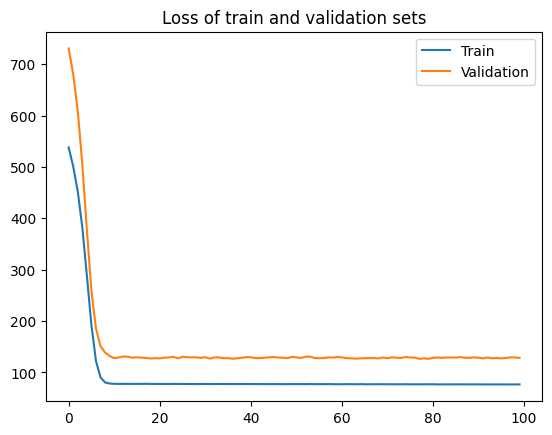

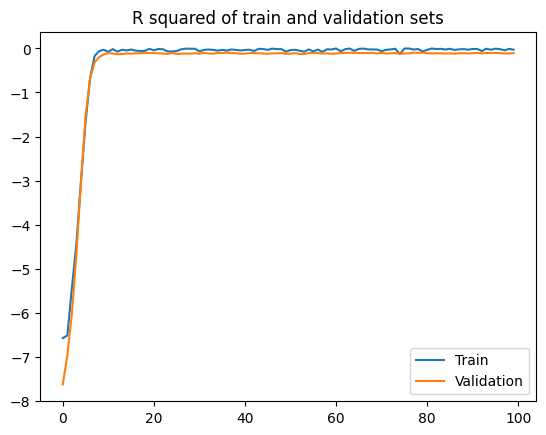

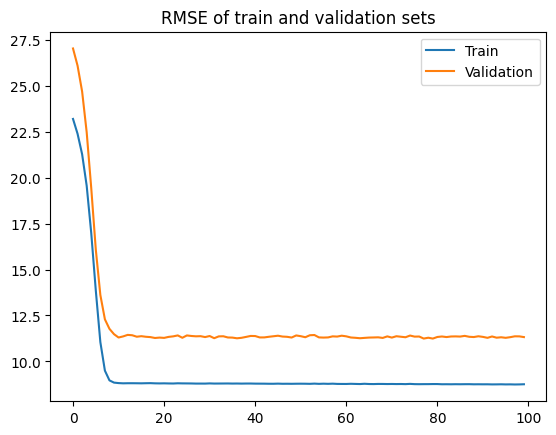

The metrics for the testing set are:
Rsquared: 0.003923761084049127
MSE: 75.63800811767578
RMSE: 8.69701099395752
Training time: 12.240345478057861 seconds


In [68]:
optim = keras.optimizers.SGD(learning_rate=0.001)
loss_func = keras.losses.MeanSquaredError()

model_1.compile(optimizer=optim, loss=loss_func, metrics=[coeff_determination, RootMeanSquaredError()])

st = time.time()

history = model_1.fit(x_train_transformed, y_train, epochs=100, validation_split=0.2)

end = time.time()

loss_acc_plot(history)

prediction_metrics(x_test, y_test, model_1, centers)

print('Training time:', end-st, 'seconds')

## Case 2: Number of RBF neurons is the 50% of the training data

In [69]:
# Number of RBF neurons is the 50% of the training data
rbf_neurons = int(0.5*np.shape(y_train)[0])
print(f'Number of rbf neurons is {rbf_neurons}')

centers = find_centers(rbf_neurons, x_train)

# Pass the train set from the rbf layer
x_train_transformed = rbf_layer(x_train, centers)

Number of rbf neurons is 189


In [70]:
model_2 = keras.Sequential([
    keras.layers.Dense(128, input_shape=(rbf_neurons,), activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               24320     
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 24,449
Trainable params: 24,449
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
10/10 [==============================] - 1s 37ms/step - loss: 538.8708 - coeff_determination: -6.5509 - root_mean_squared_error: 23.2136 - val_loss: 733.8693 - val_coeff_determination: -7.6687 - val_root_mean_squared_error: 27.0900
Epoch 2/100
10/10 [==============================] - 0s 10ms/step - loss: 504.6599 - coeff_determination: -6.3102 - root_mean_squared_error: 22.4646 - val_loss: 686.8158 - val_coeff_determination: -7.0423 - val_root_mean_squared_error: 26.2072
Epoch 3/100
10/10 [==============================] - 0s 10ms/step - loss: 457.5758 - coeff_determination: -5.5287 - root_mean_squared_error: 21.3910 - val_loss: 617.0480 - val_coeff_determination: -6.1182 - val_root_mean_squared_error: 24.8405
Epoch 4/100
10/10 [==============================] - 0s 10ms/step - loss: 388.1931 - coeff_determination: -4.6223 - root_mean_squared_error: 19.7026 - val_loss: 513.4588 - val_coeff_determination: -4.7585 - val_root_mean_squared_error: 22.6596
Epoch 5/100
10/10 [=====

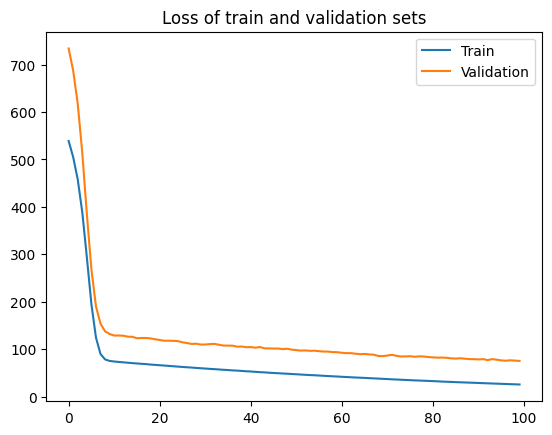

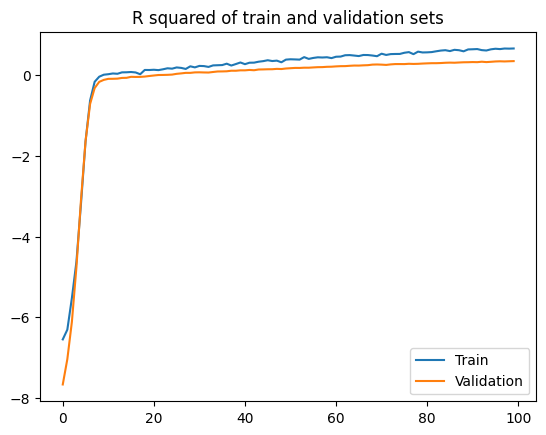

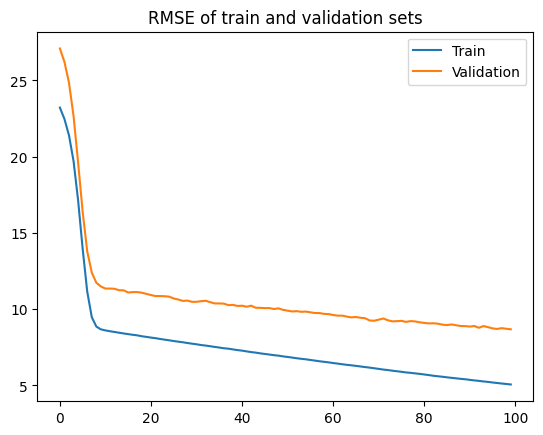

The metrics for the testing set are:
Rsquared: 0.38624552997286987
MSE: 46.60603332519531
RMSE: 6.826861381530762
Training time: 11.87882661819458 seconds


In [71]:
optim = keras.optimizers.SGD(learning_rate=0.001)
loss_func = keras.losses.MeanSquaredError()

model_2.compile(optimizer=optim, loss=loss_func, metrics=[coeff_determination, RootMeanSquaredError()])

st = time.time()

history = model_2.fit(x_train_transformed, y_train, epochs=100, validation_split=0.2)

end = time.time()

loss_acc_plot(history)

prediction_metrics(x_test, y_test, model_2, centers)

print('Training time:', end-st, 'seconds')

## Case 3: Number of RBF neurons is the 90% of the training data

In [72]:
# Number of RBF neurons is the 90% of the training data
rbf_neurons = int(0.9*np.shape(y_train)[0])
print(f'Number of rbf neurons is {rbf_neurons}')

centers = find_centers(rbf_neurons, x_train)

# Pass the train set from the rbf layer
x_train_transformed = rbf_layer(x_train, centers)

Number of rbf neurons is 341


In [73]:
model_3 = keras.Sequential([
    keras.layers.Dense(128, input_shape=(rbf_neurons,), activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

model_3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               43776     
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 43,905
Trainable params: 43,905
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
10/10 [==============================] - 1s 39ms/step - loss: 530.7083 - coeff_determination: -6.4500 - root_mean_squared_error: 23.0371 - val_loss: 716.2175 - val_coeff_determination: -7.4576 - val_root_mean_squared_error: 26.7622
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 485.8747 - coeff_determination: -6.2284 - root_mean_squared_error: 22.0426 - val_loss: 656.7937 - val_coeff_determination: -6.6812 - val_root_mean_squared_error: 25.6280
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 426.9341 - coeff_determination: -4.8946 - root_mean_squared_error: 20.6624 - val_loss: 570.7424 - val_coeff_determination: -5.5529 - val_root_mean_squared_error: 23.8902
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 341.4930 - coeff_determination: -3.7234 - root_mean_squared_error: 18.4795 - val_loss: 446.5426 - val_coeff_determination: -3.9293 - val_root_mean_squared_error: 21.1316
Epoch 5/100
10/10 [=====

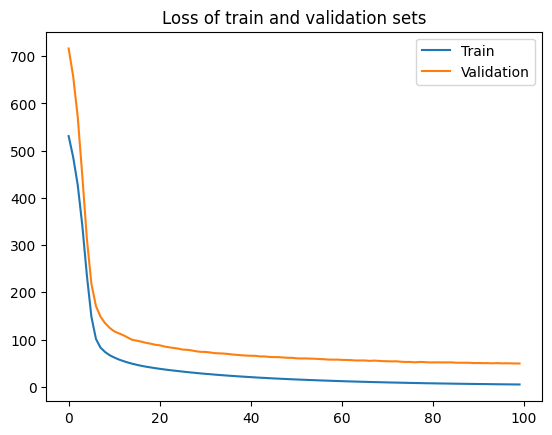

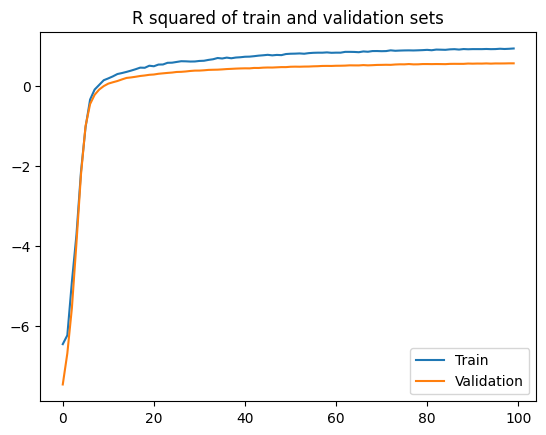

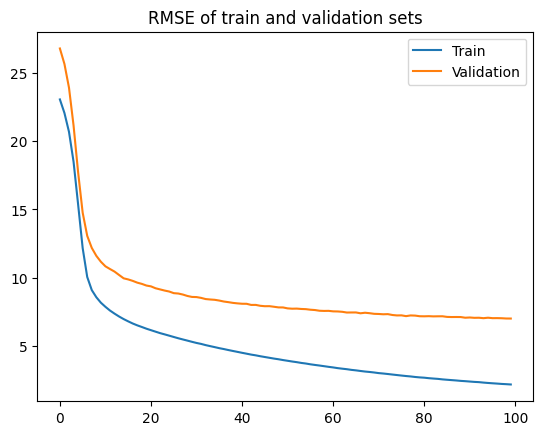

The metrics for the testing set are:
Rsquared: 0.491331040904074
MSE: 38.62626266479492
RMSE: 6.21500301361084
Training time: 13.480223894119263 seconds


In [74]:
optim = keras.optimizers.SGD(learning_rate=0.001)
loss_func = keras.losses.MeanSquaredError()

model_3.compile(optimizer=optim, loss=loss_func, metrics=[coeff_determination, RootMeanSquaredError()])

st = time.time()

history = model_3.fit(x_train_transformed, y_train, epochs=100, validation_split=0.2)

end = time.time()

loss_acc_plot(history)

prediction_metrics(x_test, y_test, model_3, centers)

print('Training time:', end-st, 'seconds')